# 5.10 転移学習とファインチューニング

<font color="blue">[自分へのメモ]</font>
loss="sparse_categorical_crossentropy" ではなく loss="categorical_crossentropy" を使う。
そのために正解ラベル(t_train, t_test)を one-hot vector 化(t_train_cat, t_test_cat)して使う。

<font color="red">[自分へのメモ]</font>
loss="categorical_crossentropy" でgenerator を使って学習するとaccがまったく向上しない。generatorを使わずにやってみてもaccが全く向上しない。<font color="red"><b>要調査</b></font>。

<font color="red">[自分へのメモ]</font> (2020/03/22 追記)
3月の初旬にMac上で jupyter notebook を動作させた時は、以下の学習 model.fit() で全く精度が上がらなかった。
本日 Windows PC (GPU付き) 上で juypter notebook を動作させたときは、普通に学習できた。何故？

## tensorflow.keras.applications に収録されている学習済みのモデル

Xception, VGG16, VGG19, ResNet50, InceptionV3, InceptionResNetV2, MobileNet, DenseNet121, DenseNet169, DenseNet201

## VGG16 モデルで CIFAR-10 を分類する

VGG16は合計が16層の入力層とConvolution層から構成されている。
入力の次元は (None, 224, 224, 3) である。
第5ブロック(最後は MaxPooling2D 層)までを利用し、Flatten, Dense, Dense(出力 None,1) を追加して利用することにする。

## ファインチューニングをプログラミングする



In [1]:
# 5-10-1 CIFAR-10 を読み込む
# p.360

import tensorflow as tf
from tensorflow import keras

(x_train, t_train), (x_test, t_test) = keras.datasets.cifar10.load_data()

print(x_train.shape)
print(t_train.shape)

(50000, 32, 32, 3)
(50000, 1)


In [2]:
# 5-10-1 画像を 64x64 にリサイズする
# p.360

x_train_rs = tf.image.resize(x_train,[64,64])
x_test_rs = tf.image.resize(x_test,[64,64])

print(x_train_rs.shape)
print(x_test_rs.shape)

(50000, 64, 64, 3)
(10000, 64, 64, 3)


<font color="blue">[自分へのメモ]</font>
tf.keras.applications に VGG16 と VGG19 も用意されている。
<a href="https://keras.io/api/applications/vgg/">デフォルトの入力サイズは 224x244で、フォーマットは channels_first (channels, height, width) でも channels_last (height, width, channels) のどちらでもよい</a>。
tf.karas.applications は 入力の前処理を前提としており、vgg16 モデルの場合は <code>tf.keras.applications.vgg16.preprocess_input</code>を呼ぶ必要があるとのこと。

以下ののコードでは前処理を行っていないが、本来は次のように入力データを前処理したものを与えた方が、よい結果を得られることが多いようだ。

<code>
    x_train_prep = tf.keras.applications.vgg16.preprocess_input(x_train_rs)
</code>

In [3]:
# 5-10-2 VGG16 をロードして、特定の層のみを学習可能に変更する
# p.361
# [自分へのメモ] 関数を呼び出して、モデルを新しく作成して返すように変更した。

 def getVGG16(input_dims,n):
    model = tf.keras.applications.VGG16(
        include_top=False,               ### 全結合層は含まない
        weights='imagenet',               ### ImageNet で学習した重みを利用する
        input_shape=input_dims           ### 入力データの形状
        )
    for layer in model.layers[:n]:   ### 0-(n-1)層の重みを固定する
        layer.trainable = False
    for layer in model.layers[n:]:   ### n層以降は重みを学習する
        layer.trainable = True
    return model

In [4]:
# 5-10-2 VGG16を用いてモデルを生成する
# p.361
from tensorflow.keras import models, layers

def getModel(org_model, output_dim):
    model = models.Sequential()
    model.add(org_model)
    model.add(layers.GlobalMaxPooling2D())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(output_dim, activation='softmax'))
    return model

In [5]:
t_train_cat = keras.utils.to_categorical(t_train, 10)
t_test_cat = keras.utils.to_categorical(t_test, 10)

In [6]:
model = getModel(getVGG16(x_train_rs[0].shape, 15), 10)

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
    )

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_max_pooling2d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               262656    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 14,982,474
Trainable params: 7,347,210
Non-trainable params: 7,635,264
_________________________________________________________________


In [7]:
# 普通に学習してみる

x_tr = x_train_rs / 255
x_te = x_test_rs / 255

history = model.fit(
    x_tr,
    t_train_cat,
    batch_size=64,
    epochs=30,
    validation_data=(x_te, t_test_cat)
    )

Epoch 1/30
782/782 [==============================] - 24s 30ms/step - loss: 0.9773 - accuracy: 0.6588 - val_loss: 0.6614 - val_accuracy: 0.7769
Epoch 2/30
782/782 [==============================] - 22s 29ms/step - loss: 0.5826 - accuracy: 0.8043 - val_loss: 0.5839 - val_accuracy: 0.8080
Epoch 3/30
782/782 [==============================] - 23s 29ms/step - loss: 0.4793 - accuracy: 0.8390 - val_loss: 0.5874 - val_accuracy: 0.8089
Epoch 4/30
782/782 [==============================] - 24s 31ms/step - loss: 0.3864 - accuracy: 0.8693 - val_loss: 0.6082 - val_accuracy: 0.8119
Epoch 5/30
782/782 [==============================] - 23s 30ms/step - loss: 0.3253 - accuracy: 0.8908 - val_loss: 0.6112 - val_accuracy: 0.8122
Epoch 6/30
782/782 [==============================] - 23s 29ms/step - loss: 0.2733 - accuracy: 0.9071 - val_loss: 0.6174 - val_accuracy: 0.8177
Epoch 7/30
782/782 [==============================] - 23s 29ms/step - loss: 0.2346 - accuracy: 0.9214 - val_loss: 0.7161 - val_accuracy:

In [8]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [9]:
# 5-02-23 損失と精度の推移をグラフにする
# p.317
# [自分へのメモ] 独自のコードで書き直した

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(6*2, 4))
    
    ax[0].plot(history['accuracy'], "-", label="accuracy",c="blue")
    ax[0].plot(history['val_accuracy'], "-", label="val_accuracy",c="green")
    ax[0].set_title('model accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(loc="lower right")
    
    ax[1].plot(history['loss'], "-", label="loss", c="blue")
    ax[1].plot(history['val_loss'], "-", label="val_loss", c="green")
    ax[1].set_title('model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(loc="upper left")

    
    plt.subplots_adjust(wspace=0.1)
    plt.show()

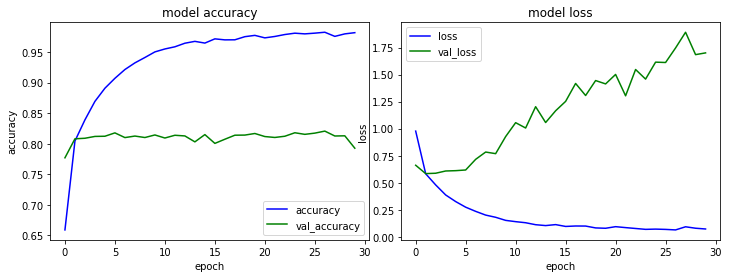

In [10]:
plot_history(history.history)

## Data Augmentation を使う

In [11]:
# 5-10-3 DataAugmentation
# p.366

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64

datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2
    )

training_generator = datagen.flow(
    x_train_rs,
    t_train_cat,
    batch_size=batch_size,
    subset='training'
    )

validation_generator = datagen.flow(
    x_train_rs,
    t_train_cat,
    batch_size=batch_size,
    subset='validation'
    )

In [12]:
# 5-10-3 学習率を減衰する
# p.367
import math

def step_decay(epoch):
    initial_lrate = 0.001   # 学習率の初期値 
    drop = 0.5              # 減衰率
    epochs_drop = 10.0      # 10エポック毎に減衰する
    lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
    return lrate

# 学習率のコールバック
lrate = keras.callbacks.LearningRateScheduler(step_decay)

In [13]:
# 5-10-3 学習する
# p.367

model2 = getModel(getVGG16(x_train_rs[0].shape, 15), 10)

model2.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(lr=0.001),
    metrics=['accuracy']
    )

epochs = 50

history2 = model2.fit(
    training_generator,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    callbacks=[lrate]
    )

Epoch 1/50
625/625 [==============================] - 43s 69ms/step - loss: 1.3563 - accuracy: 0.5019 - val_loss: 0.8512 - val_accuracy: 0.7079
Epoch 2/50
625/625 [==============================] - 41s 65ms/step - loss: 0.8300 - accuracy: 0.7223 - val_loss: 0.8018 - val_accuracy: 0.7297
Epoch 3/50
625/625 [==============================] - 42s 67ms/step - loss: 0.7269 - accuracy: 0.7554 - val_loss: 0.7351 - val_accuracy: 0.7500
Epoch 4/50
625/625 [==============================] - 42s 67ms/step - loss: 0.6673 - accuracy: 0.7738 - val_loss: 0.7447 - val_accuracy: 0.7518
Epoch 5/50
625/625 [==============================] - 41s 66ms/step - loss: 0.6258 - accuracy: 0.7893 - val_loss: 0.6798 - val_accuracy: 0.7724
Epoch 6/50
625/625 [==============================] - 41s 66ms/step - loss: 0.5957 - accuracy: 0.7975 - val_loss: 0.7012 - val_accuracy: 0.7672
Epoch 7/50
625/625 [==============================] - 41s 65ms/step - loss: 0.5701 - accuracy: 0.8095 - val_loss: 0.6774 - val_accuracy:

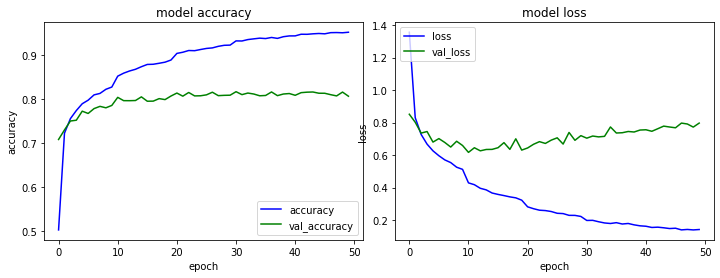

In [14]:
plot_history(history2.history)

In [18]:
loss, acc = model2.evaluate(x_te, t_test_cat)
print(f'loss: {loss:.4f}  acc: {acc:.4f}')

313/313 [==============================] - 4s 12ms/step - loss: 0.6934 - accuracy: 0.8394
loss: 0.6934  acc: 0.8394
